
# 1. Calculating Five Point Summary and Rendering Boxplot

In [1]:
import findspark
findspark.init()

In [2]:
from pyspark.sql import SparkSession
import pandas as pd
import numpy as np

In [3]:
sparkSession = SparkSession.builder \
       .master("local") \
       .appName("Spark ML") \
       .getOrCreate()

In [20]:
sparkDf = sparkSession.read.format("csv").option("delimiter"," "). \
option("inferSchema","true").load("../PySpark_repo/meta_data/LifeExpentancy.txt")

In [21]:
committersDF = sparkSession.read.format("csv").option("header", True).option("delimiter", "\t").load("file:///stackexchange/spark-committers.tsv")

AnalysisException: Path does not exist: file:/stackexchange/spark-committers.tsv;

In [7]:
sparkDf.printSchema()
sparkDf.head()

root
 |-- _c0: string (nullable = true)
 |-- _c1: string (nullable = true)
 |-- _c2: double (nullable = true)
 |-- _c3: string (nullable = true)
 |-- _c4: string (nullable = true)



Row(_c0='Afghanistan', _c1=None, _c2=48.673, _c3=None, _c4='SAs')

In [8]:
from pyspark.sql.types import StructType,StructField,DoubleType,StringType
schema = StructType([
	   StructField("Country",StringType()),
	   StructField("LifeExp",DoubleType()),
	   StructField("Region",StringType())
])
selectedDF = sparkDf.select("_c0","_c2","_c4")
lifeExpectancyDF = sparkSession.createDataFrame(selectedDF.rdd,schema)

In [11]:
lifeExpectancyDF.show(5)

+-----------+-------+------+
|    Country|LifeExp|Region|
+-----------+-------+------+
|Afghanistan| 48.673|   SAs|
|    Albania| 76.918|  EuCA|
|    Algeria| 73.131|  MENA|
|     Angola| 51.093|   SSA|
|  Argentina| 75.901|  Amer|
+-----------+-------+------+
only showing top 5 rows



In [12]:
summary = lifeExpectancyDF.describe("LifeExp")
summary.printSchema()
summary.show()
pandaDf = summary.toPandas()
min_string = pandaDf[pandaDf['summary'] == 'min']['LifeExp'].iloc[0]
max_string = pandaDf[pandaDf['summary'] == 'max']['LifeExp'].iloc[0]
mean_string = pandaDf[pandaDf['summary'] == 'mean']['LifeExp'].iloc[0]

root
 |-- summary: string (nullable = true)
 |-- LifeExp: string (nullable = true)

+-------+-----------------+
|summary|          LifeExp|
+-------+-----------------+
|  count|              197|
|   mean|69.86281725888323|
| stddev|9.668736205594511|
|    min|           47.794|
|    max|           83.394|
+-------+-----------------+



In [13]:
medianAndQuantiles = lifeExpectancyDF.stat.approxQuantile("LifeExp",[0.25,0.5,0.75],0.0)
(q1,median,q3) = (medianAndQuantiles[0], medianAndQuantiles[1], medianAndQuantiles[2])

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

In [16]:
# Rendering box plot from actual data
#plt.boxplot(fivepointsummary)
#plt.show()

NameError: name 'fivepointsummary' is not defined

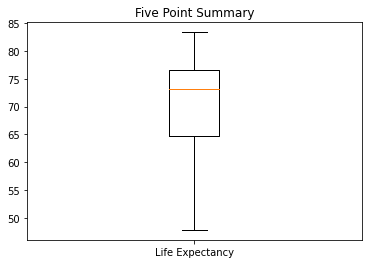

In [17]:
#Boxplot from precomputed values
item = {}

item["label"] = 'Life Expectancy' 
item["mean"] = float(mean_string) 
item["med"] = median 
item["q1"] = q1
item["q3"] = q3
item["whislo"] = float(min_string) 
item["whishi"] = float(max_string)
item["fliers"] = []
stats = [item]

fig, axes = plt.subplots(1, 1)
axes.bxp(stats)
axes.set_title('Five Point Summary')
plt.show()

# 2.Histograms

In [18]:
(startValues,counts) = lifeExpectancyDF.select("LifeExp").rdd.map(lambda value: value[0]).histogram(5)
print(startValues)
print(counts)

[47.794, 54.914, 62.034, 69.154, 76.274, 83.394]
[24, 18, 32, 69, 54]


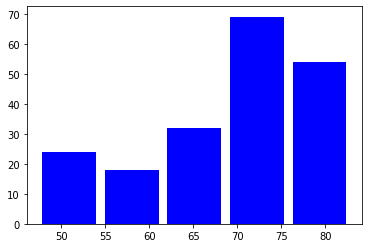

In [19]:
mid_point_bins = startValues[:-1]
widths = [abs(i - j+1) for i, j in zip(startValues[:-1], startValues[1:])]
bar = plt.bar(mid_point_bins, counts, width=widths, color='b', align='edge')
plt.show()